In [1]:
pip install opencv-contrib-python 

Looking in indexes: http://mirrors.aliyun.com/pypi/simple
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pandas

Looking in indexes: http://mirrors.aliyun.com/pypi/simple
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install seaborn

Looking in indexes: http://mirrors.aliyun.com/pypi/simple
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install plotly

Looking in indexes: http://mirrors.aliyun.com/pypi/simple
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install scikit-learn

Looking in indexes: http://mirrors.aliyun.com/pypi/simple
Note: you may need to restart the kernel to use updated packages.


In [6]:
import os
import shutil
import itertools
import pathlib
from PIL import Image

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import seaborn as sns
sns.set_style('whitegrid')
import plotly.express as px

from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

from tqdm import tqdm  # Import tqdm for progress bar

import warnings
warnings.filterwarnings('ignore')
print('Using PyTorch version', torch.__version__)
# Setup device-agnostic code

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


Using PyTorch version 2.2.1+cu121


device(type='cuda')

In [7]:
transform= transforms.ToTensor()

In [8]:
metadata = pd.read_csv('ISIC_2019_Training_Metadata.csv')
ground_truth = pd.read_csv('ISIC_2019_Training_GroundTruth.csv')
# Concatenate the two DataFrames based on the 'image' column
df = pd.merge(ground_truth, metadata, on='image').drop('lesion_id', axis=1)
df['target'] = df[['MEL', 'NV', 'BCC', 'AK', 'DF', 'VASC', 'SCC', 'UNK']].sum(axis=1) # 1 for Malignant || 0 for Benign
diagnosis_map = {0: 'benign', 1: 'malignant'}
df['diagnosis'] = df['target'].map(diagnosis_map)
data = df.loc[:, ['image', 'age_approx', 'anatom_site_general', 'sex', 'target', 'diagnosis']]
data['image'] = 'autodl-tmp/ISIC_2019_Training_Input/' + data['image'] + '.jpg'
# data['anatom_site_general'] = data['anatom_site_general'].replace(['lateral torso', 'anterior torso', 'posterior torso'], 'torso')
data

,image,age_approx,anatom_site_general,sex,target,diagnosis
0,autodl-tmp/ISIC_2019_Training_Input/ISIC_00000...,55.0,anterior torso,female,1.0,malignant
1,autodl-tmp/ISIC_2019_Training_Input/ISIC_00000...,30.0,anterior torso,female,1.0,malignant
2,autodl-tmp/ISIC_2019_Training_Input/ISIC_00000...,60.0,upper extremity,female,1.0,malignant
3,autodl-tmp/ISIC_2019_Training_Input/ISIC_00000...,30.0,upper extremity,male,1.0,malignant
4,autodl-tmp/ISIC_2019_Training_Input/ISIC_00000...,80.0,posterior torso,male,1.0,malignant
...,...,...,...,...,...,...
25326,autodl-tmp/ISIC_2019_Training_Input/ISIC_00732...,85.0,head/neck,female,1.0,malignant
25327,autodl-tmp/ISIC_2019_Training_Input/ISIC_00732...,65.0,anterior torso,male,0.0,benign
25328,autodl-tmp/ISIC_2019_Training_Input/ISIC_00732...,70.0,lower extremity,male,1.0,malignant
25329,autodl-tmp/ISIC_2019_Training_Input/ISIC_00732...,55.0,palms/soles,female,1.0,malignant


In [9]:
isic_data = pd.read_csv('train.csv').drop(['patient_id', 'diagnosis'],axis=1)

# Selecting specific columns using .loc[]
isic_Data = isic_data.loc[:, ['image_name', 'age_approx', 'anatom_site_general_challenge', 'sex', 'target', 'benign_malignant']]
isic_data = isic_data.rename(columns={
    'image_name' : 'image',
    'anatom_site_general_challenge': 'anatom_site_general',
    'benign_malignant': 'diagnosis',
})

column_order = ['image', 'age_approx', 'anatom_site_general', 'sex', 'target', 'diagnosis']

isic_data = isic_data[column_order]

# Update the image column with the path to the image
isic_data['image'] = 'autodl-tmp/jpeg/train/' + isic_data['image'] + '.jpg'
isic_data

,image,age_approx,anatom_site_general,sex,target,diagnosis
0,autodl-tmp/jpeg/train/ISIC_2637011.jpg,45.0,head/neck,male,0,benign
1,autodl-tmp/jpeg/train/ISIC_0015719.jpg,45.0,upper extremity,female,0,benign
2,autodl-tmp/jpeg/train/ISIC_0052212.jpg,50.0,lower extremity,female,0,benign
3,autodl-tmp/jpeg/train/ISIC_0068279.jpg,45.0,head/neck,female,0,benign
4,autodl-tmp/jpeg/train/ISIC_0074268.jpg,55.0,upper extremity,female,0,benign
...,...,...,...,...,...,...
33121,autodl-tmp/jpeg/train/ISIC_9999134.jpg,50.0,torso,male,0,benign
33122,autodl-tmp/jpeg/train/ISIC_9999320.jpg,65.0,torso,male,0,benign
33123,autodl-tmp/jpeg/train/ISIC_9999515.jpg,20.0,lower extremity,male,0,benign
33124,autodl-tmp/jpeg/train/ISIC_9999666.jpg,50.0,lower extremity,male,0,benign


In [10]:
# Concatenating the two DataFrames
combined_data = pd.concat([isic_data, data], ignore_index=True).reset_index(drop=True)

combined_data

,image,age_approx,anatom_site_general,sex,target,diagnosis
0,autodl-tmp/jpeg/train/ISIC_2637011.jpg,45.0,head/neck,male,0.0,benign
1,autodl-tmp/jpeg/train/ISIC_0015719.jpg,45.0,upper extremity,female,0.0,benign
2,autodl-tmp/jpeg/train/ISIC_0052212.jpg,50.0,lower extremity,female,0.0,benign
3,autodl-tmp/jpeg/train/ISIC_0068279.jpg,45.0,head/neck,female,0.0,benign
4,autodl-tmp/jpeg/train/ISIC_0074268.jpg,55.0,upper extremity,female,0.0,benign
...,...,...,...,...,...,...
58452,autodl-tmp/ISIC_2019_Training_Input/ISIC_00732...,85.0,head/neck,female,1.0,malignant
58453,autodl-tmp/ISIC_2019_Training_Input/ISIC_00732...,65.0,anterior torso,male,0.0,benign
58454,autodl-tmp/ISIC_2019_Training_Input/ISIC_00732...,70.0,lower extremity,male,1.0,malignant
58455,autodl-tmp/ISIC_2019_Training_Input/ISIC_00732...,55.0,palms/soles,female,1.0,malignant


,Feature Name,Number of Nulls
0,image,0
1,age_approx,505
2,anatom_site_general,3158
3,sex,449
4,target,0
5,diagnosis,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58457 entries, 0 to 58456
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   image                58457 non-null  object 
 1   age_approx           57952 non-null  float64
 2   anatom_site_general  55299 non-null  object 
 3   sex                  58008 non-null  object 
 4   target               58457 non-null  float64
 5   diagnosis            58457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 2.7+ MB
None


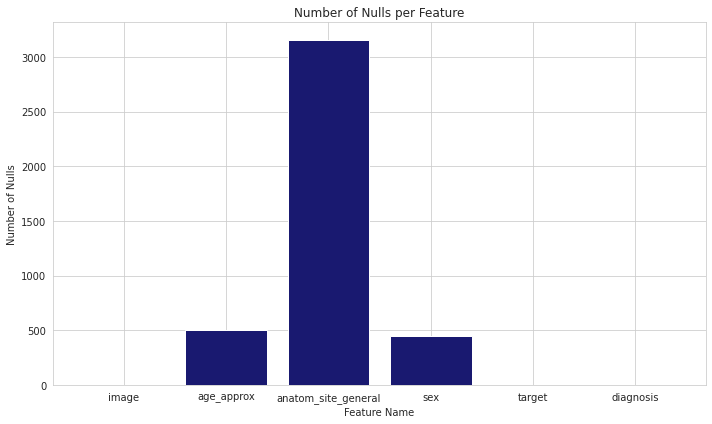

,Feature Name,Number of Nulls
0,image,0
1,age_approx,0
2,anatom_site_general,0
3,sex,0
4,target,0
5,diagnosis,0


<class 'pandas.core.frame.DataFrame'>
Index: 55011 entries, 0 to 58456
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   image                55011 non-null  object 
 1   age_approx           55011 non-null  float64
 2   anatom_site_general  55011 non-null  object 
 3   sex                  55011 non-null  object 
 4   target               55011 non-null  float64
 5   diagnosis            55011 non-null  object 
dtypes: float64(2), object(4)
memory usage: 2.9+ MB
None


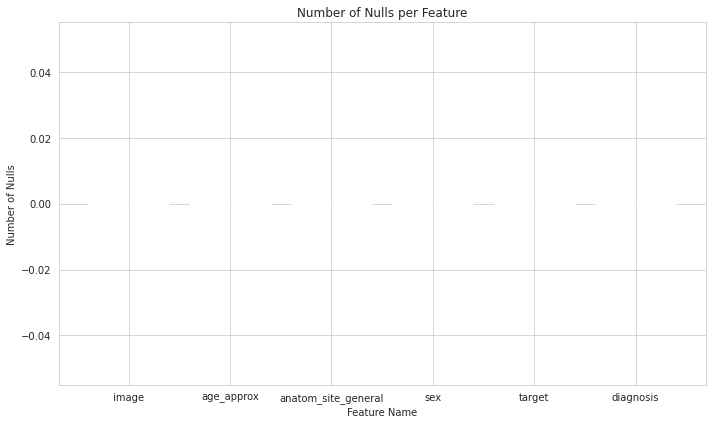

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
def null_analysis(data):
    df_null_info = pd.DataFrame(columns=['Feature Name', 'Number of Nulls'])
    for data_label in data.columns.tolist():
        num_nulls = data[data_label].isnull().sum()
        df_null_info = pd.concat([df_null_info, pd.DataFrame({'Feature Name': [data_label], 'Number of Nulls': [num_nulls]})], ignore_index=True)
    display(df_null_info)
    print(data.info())

    plt.figure(figsize=(10, 6))
    plt.bar(df_null_info['Feature Name'], df_null_info['Number of Nulls'], color='midnightblue')
    plt.xlabel('Feature Name')
    plt.ylabel('Number of Nulls')
    plt.title('Number of Nulls per Feature')

    # Show the plot
    plt.tight_layout()
    plt.show()

null_analysis(combined_data)
combined_data = combined_data.dropna()
null_analysis(combined_data)

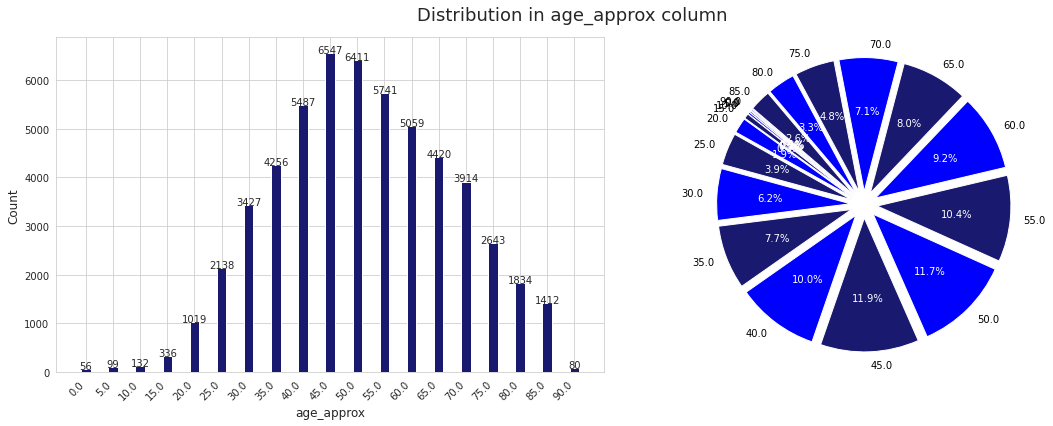

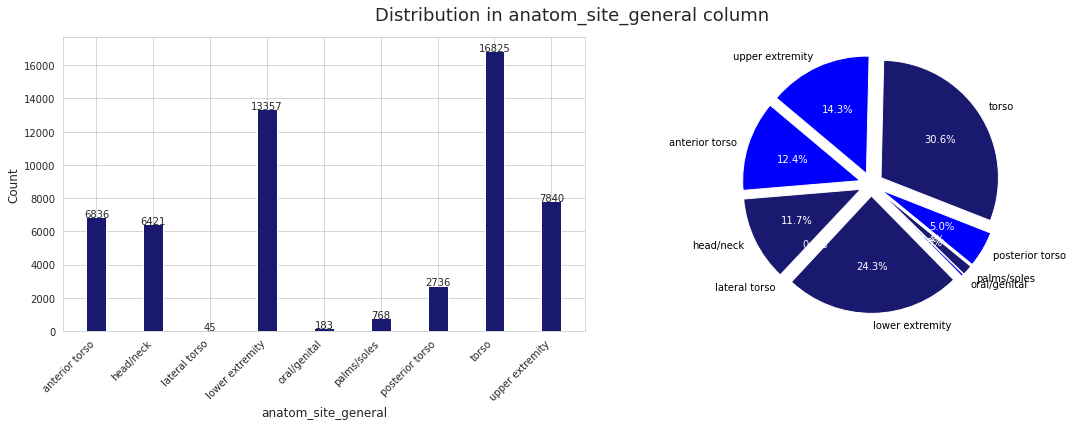

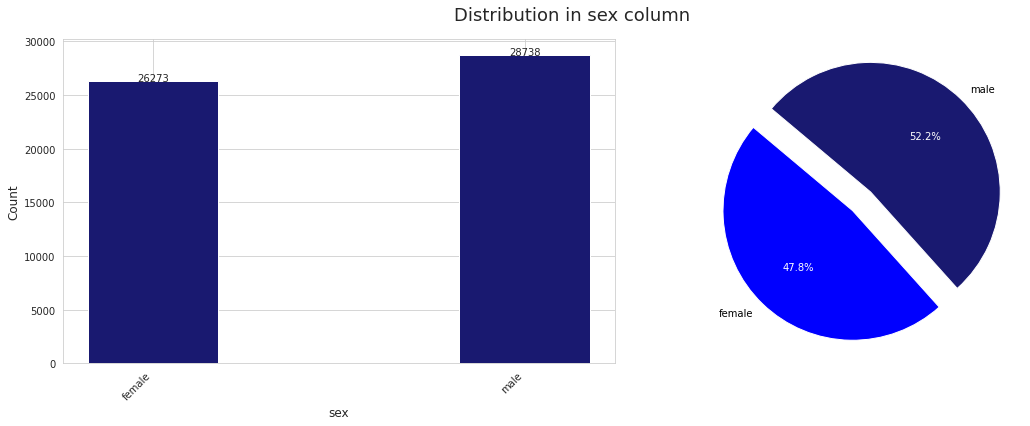

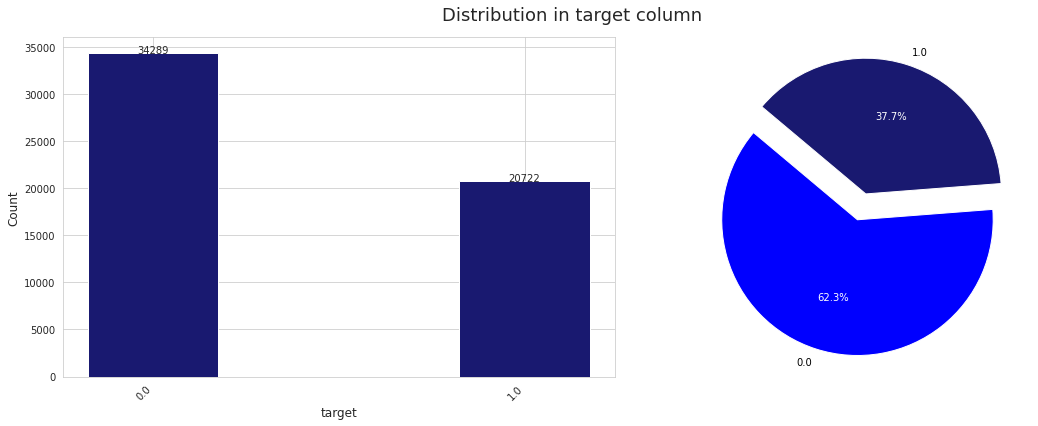

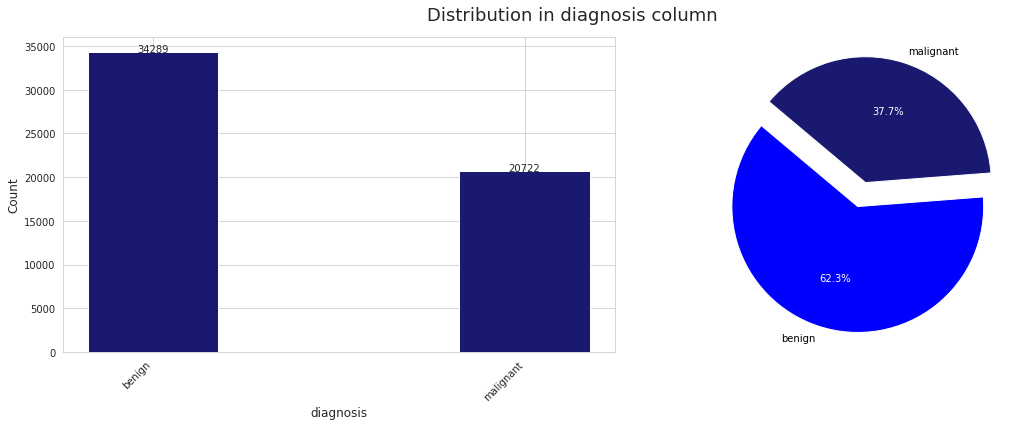

In [12]:
def plot_distribution(dataframe, target_column):
    # Calculate value counts and sort them
    value_counts = dataframe[target_column].value_counts().sort_index()

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Bar plot on the first subplot
    bar_width = 0.35
    ind = np.arange(len(value_counts))
    rects = ax1.bar(ind, value_counts.values, width=bar_width, color='midnightblue')
    ax1.set_xlabel(target_column, fontsize=12)
    ax1.set_ylabel('Count', fontsize=12)
    ax1.set_xticks(ind)
    ax1.set_xticklabels(value_counts.index, rotation=45, ha='right', fontsize=10)

    # Add values on top of bars
    for index, value in enumerate(value_counts.values):
        ax1.text(index, value + 0.1, str(value), ha='center', fontsize=10)

    # Pie plot 
    explode = [0.1 for i in range(len(value_counts))]
    patches, texts, autotexts = ax2.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', colors=["blue","midnightblue"], explode=explode, startangle=140)

    # Adjust the distance of the labels from the center
    for text in texts:
        text.set_color('black')
        text.set_fontsize(10)
    for autotext in autotexts:
        autotext.set_fontsize(10)
        autotext.set_color('white')
    # Main title for the figure
    fig.suptitle(f'Distribution in {target_column} column', fontsize=18)
    
    # Adjust layout and display the figure
    plt.tight_layout()
    plt.show()
    
for column in data.columns:
    if column == 'image':
        continue
    plot_distribution(combined_data, column)

In [13]:
labelencoder= LabelEncoder() 
combined_data['anatom_site_general_encoded'] = labelencoder.fit_transform(combined_data['anatom_site_general']) 
combined_data['sex_encoded'] = labelencoder.fit_transform(combined_data['sex']) 
combined_data['diagnosis_encoded'] = labelencoder.fit_transform(combined_data['diagnosis'])
combined_data_NoC=combined_data.drop(['anatom_site_general', 'sex', 'diagnosis'], axis=1)
# scale the age
scaler = MinMaxScaler()
combined_data_NoC['age_approx'] = scaler.fit_transform( combined_data_NoC['age_approx'].values.reshape(-1, 1))

combined_data_NoC.head()

,image,age_approx,target,anatom_site_general_encoded,sex_encoded,diagnosis_encoded
0,autodl-tmp/jpeg/train/ISIC_2637011.jpg,0.500000,0.0,1,1,0
1,autodl-tmp/jpeg/train/ISIC_0015719.jpg,0.500000,0.0,8,0,0
2,autodl-tmp/jpeg/train/ISIC_0052212.jpg,0.555556,0.0,3,0,0
3,autodl-tmp/jpeg/train/ISIC_0068279.jpg,0.500000,0.0,1,0,0
4,autodl-tmp/jpeg/train/ISIC_0074268.jpg,0.611111,0.0,8,0,0


In [14]:
train_data, test_data = train_test_split(combined_data_NoC, test_size=0.3, stratify=combined_data_NoC['target'], random_state=42)
valid_data, test_data = train_test_split(test_data, test_size=0.5, stratify=test_data['target'], random_state=42)

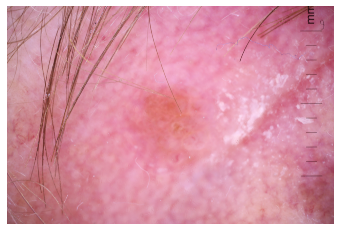

,image,age_approx,target,anatom_site_general_encoded,sex_encoded,diagnosis_encoded
34258,autodl-tmp/ISIC_2019_Training_Input/ISIC_00111...,0.666667,1.0,3,0,1
10846,autodl-tmp/jpeg/train/ISIC_3349562.jpg,0.222222,0.0,3,1,0
51270,autodl-tmp/ISIC_2019_Training_Input/ISIC_00618...,0.833333,0.0,0,0,0
46910,autodl-tmp/ISIC_2019_Training_Input/ISIC_00548...,0.833333,1.0,0,1,1
38073,autodl-tmp/ISIC_2019_Training_Input/ISIC_00263...,0.333333,1.0,6,0,1
...,...,...,...,...,...,...
37494,autodl-tmp/ISIC_2019_Training_Input/ISIC_00257...,0.388889,1.0,3,0,1
1602,autodl-tmp/jpeg/train/ISIC_0584566.jpg,0.444444,0.0,8,1,0
803,autodl-tmp/jpeg/train/ISIC_0343957.jpg,0.444444,0.0,8,0,0
29621,autodl-tmp/jpeg/train/ISIC_8961663.jpg,0.944444,0.0,7,0,0


In [15]:
from PIL import Image
import matplotlib.pyplot as plt

# Define the file path of the image you want to display
image_path = 'autodl-tmp/jpeg/train/ISIC_2637011.jpg'

# Open the image using PI
image = Image.open(image_path)

# Display the image using matplotlib
plt.figure()
plt.imshow(image)
plt.axis('off')  # Turn off the axis
plt.show()

train_data

In [16]:
from torch.utils.data import Dataset
from PIL import Image

class ImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx, 0]
        image = Image.open(img_name)

        if self.transform:
            image = self.transform(image)

        label = torch.tensor(self.dataframe.iloc[idx, 5], dtype=torch.long)

        return image, label


In [17]:
from torchvision import transforms
from torch.utils.data import DataLoader

# 定义数据转换
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.5),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=5)], p=0.5),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=7)], p=0.5),
    transforms.RandomApply([transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10)], p=0.5),
    transforms.RandomApply([transforms.RandomPerspective(distortion_scale=0.5)], p=0.5),
    transforms.ToTensor(),  
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
])

# 定义数据集和数据加载器
train_dataset = ImageDataset(train_data, transform=train_transform)
valid_dataset = ImageDataset(valid_data, transform=test_transform)
test_dataset = ImageDataset(test_data, transform=test_transform)

# 定义数据加载器
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True,num_workers=8)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False,num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=True,num_workers=8)

print('Data loading and preprocessing completed.')

Data loading and preprocessing completed.


In [18]:
valid_data


,image,age_approx,target,anatom_site_general_encoded,sex_encoded,diagnosis_encoded
13457,autodl-tmp/jpeg/train/ISIC_4131810.jpg,0.333333,0.0,1,1,0
27086,autodl-tmp/jpeg/train/ISIC_8204544.jpg,0.611111,0.0,3,0,0
32110,autodl-tmp/jpeg/train/ISIC_9699087.jpg,0.777778,0.0,7,1,0
3529,autodl-tmp/jpeg/train/ISIC_1165548.jpg,0.444444,0.0,3,1,0
50525,autodl-tmp/ISIC_2019_Training_Input/ISIC_00606...,0.888889,1.0,1,1,1
...,...,...,...,...,...,...
9422,autodl-tmp/jpeg/train/ISIC_2922270.jpg,0.388889,0.0,3,1,0
36903,autodl-tmp/ISIC_2019_Training_Input/ISIC_00251...,0.388889,0.0,0,0,0
53567,autodl-tmp/ISIC_2019_Training_Input/ISIC_00655...,0.833333,1.0,0,1,1
26310,autodl-tmp/jpeg/train/ISIC_7984569.jpg,0.555556,0.0,7,0,0


In [19]:
# Get one batch
for batch in train_loader:
    images,  labels = batch
    break


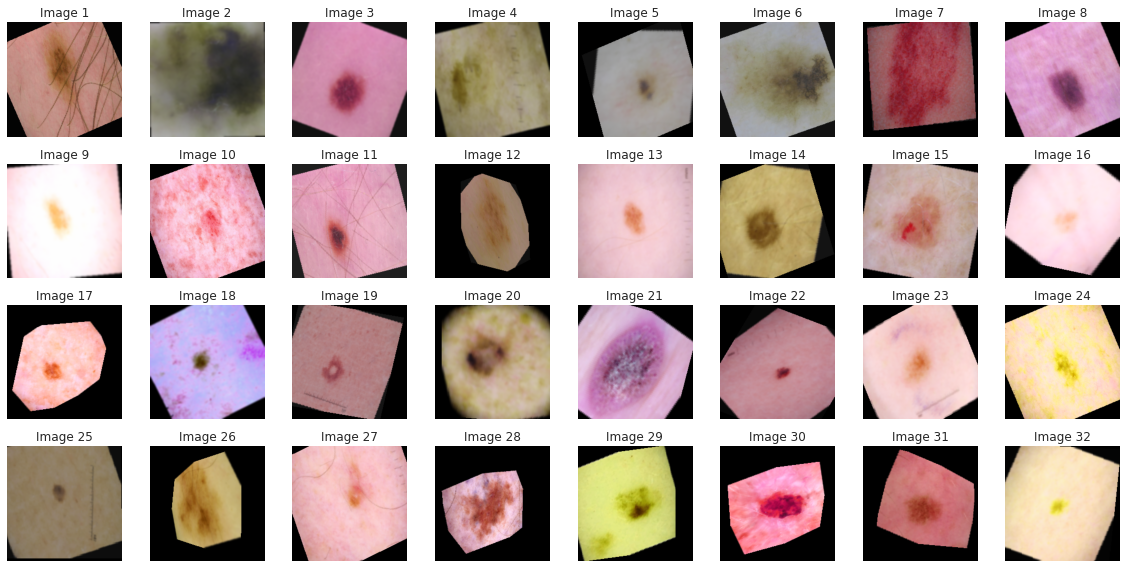

In [20]:
# Create a figure and a grid of subplots
fig, axs = plt.subplots(4, 8, figsize=(16, 8))

# Flatten the axs array so that we can iterate over subplots easily
axs = axs.flatten()

# Plot each image
for i, ax in enumerate(axs):
    ax.imshow(images[i].permute(1, 2, 0).cpu().numpy())  # Convert tensor to numpy array and permute dimensions
    ax.axis('off')  # Turn off axis
    ax.set_title(f'Image {i+1}')  # Set title for each subplot

plt.tight_layout()  # Adjust layout to make subplots fit
plt.show()


In [21]:
resnet18 = torchvision.models.resnet18(pretrained=True).to(device)

print(resnet18)
for batch in train_loader:
    images, labels = [item.to(device) for item in batch]
    break


'resnet18 = torchvision.models.resnet18(pretrained=True).to(device)\n\nprint(resnet18)\nfor batch in train_loader:\n    images, labels = [item.to(device) for item in batch]\n    break\n'

In [22]:
num_classes = 2
resnet18.fc = torch.nn.Linear(in_features=512, out_features=num_classes)

# Define loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5)

# Move model to device
resnet18.to(device)

'num_classes = 2\nresnet18.fc = torch.nn.Linear(in_features=512, out_features=num_classes)\n\n# Define loss function and optimizer\nloss_fn = torch.nn.CrossEntropyLoss()\noptimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5)\n\n# Move model to device\nresnet18.to(device)'

In [23]:
'''
# Training the model
model = resnet18
criterion = nn.CrossEntropyLoss()

# Validation function
def validate_model(model, val_loader, criterion, device):  
    model.eval()  # Set to evaluation mode  
    val_loss = 0.0  
    correct = 0  
    total = 0  
    with torch.no_grad():  
        for images, labels in tqdm(val_loader, desc="Validation"):  
            images = images.to(device)  
            labels = labels.to(device)  
            outputs = model(images)  
            loss = criterion(outputs, labels)  
            val_loss += loss.item()  
            _, predicted = torch.max(outputs, 1)  
            total += labels.size(0)  
            correct += (predicted == labels).sum().item()  
    val_loss /= len(val_loader)  
    val_accuracy = correct / total  
    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2%}")  
    return val_loss, val_accuracy  
  
# Testing function  
def test_model(model, test_loader, criterion, device):  
    model.eval()  # Set to evaluation mode  
    test_loss = 0.0  
    correct = 0  
    total = 0  
    with torch.no_grad():  
        for images, labels in tqdm(test_loader, desc="Testing"):  
            images = images.to(device)  
            labels = labels.to(device)  
            outputs = model(images)  
            loss = criterion(outputs, labels)  
            test_loss += loss.item()  
            _, predicted = torch.max(outputs, 1)  
            total += labels.size(0)  
            correct += (predicted == labels).sum().item()  
    test_loss /= len(test_loader)  
    test_accuracy = correct / total  
    print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2%}")  
    return test_loss, test_accuracy 

# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    correct = 0
    total = 0
    running_loss = 0.0
    
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct / total
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2%}")
    val_loss, val_acc = validate_model(model, valid_loader, criterion, device)  
  
    # Perform testing after validation
    test_loss, test_acc = test_model(model, test_loader, criterion, device)  

print("Training, Validation, and Testing complete!")
'''

'\n# Training the model\nmodel = resnet18\ncriterion = nn.CrossEntropyLoss()\n\n# Validation function\ndef validate_model(model, val_loader, criterion, device):  \n    model.eval()  # Set to evaluation mode  \n    val_loss = 0.0  \n    correct = 0  \n    total = 0  \n    with torch.no_grad():  \n        for images, labels in tqdm(val_loader, desc="Validation"):  \n            images = images.to(device)  \n            labels = labels.to(device)  \n            outputs = model(images)  \n            loss = criterion(outputs, labels)  \n            val_loss += loss.item()  \n            _, predicted = torch.max(outputs, 1)  \n            total += labels.size(0)  \n            correct += (predicted == labels).sum().item()  \n    val_loss /= len(val_loader)  \n    val_accuracy = correct / total  \n    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2%}")  \n    return val_loss, val_accuracy  \n  \n# Testing function  \ndef test_model(model, test_loader, criterion, device): 

In [24]:

import torch
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

# Assuming 'device', 'train_loader', 'valid_loader', 'test_loader', 'resnet18' are already defined

# Training the model
resnet18.fc = torch.nn.Linear(in_features=512, out_features=2)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5)
resnet18 = resnet18.to(device)

# Validation function
def validate_model(model, val_loader, criterion, device):  
    model.eval()  # Set to evaluation mode  
    val_loss = 0.0  
    correct = 0  
    total = 0  
    all_labels = []
    all_probs = []
    with torch.no_grad():  
        for images, labels in tqdm(val_loader, desc="Validation"):  
            images = images.to(device)  
            labels = labels.to(device)  
            outputs = model(images)  
            loss = criterion(outputs, labels)  
            val_loss += loss.item()  
            _, predicted = torch.max(outputs, 1)  
            total += labels.size(0)  
            correct += (predicted == labels).sum().item()  
            
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(torch.softmax(outputs, dim=1)[:, 1].cpu().numpy())  # Use probability of class 1
    
    # Compute AUC
    val_auc = roc_auc_score(all_labels, all_probs)
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % val_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()
    
    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {correct / total:.2%}")  

# Testing function  
def test_model(model, test_loader, criterion, device):  
    model.eval()  # Set to evaluation mode  
    test_loss = 0.0  
    correct = 0  
    total = 0  
    all_labels = []
    all_probs = []
    with torch.no_grad():  
        for images, labels in tqdm(test_loader, desc="Testing"):  
            images = images.to(device)  
            labels = labels.to(device)  
            outputs = model(images)  
            loss = criterion(outputs, labels)  
            test_loss += loss.item()  
            _, predicted = torch.max(outputs, 1)  
            total += labels.size(0)  
            correct += (predicted == labels).sum().item()  

            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(torch.softmax(outputs, dim=1)[:, 1].cpu().numpy())  # Use probability of class 1
    
    # Compute AUC
    test_auc = roc_auc_score(all_labels, all_probs)
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % test_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()
    
    print(f"Test Loss: {test_loss / len(test_loader):.4f}, Accuracy: {correct / total:.2%}")  

# Training loop
epochs = 10
for epoch in range(epochs):
    resnet18.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = resnet18(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {running_loss / len(train_loader)}")
    validate_model(resnet18, valid_loader, loss_fn, device)

# Test the model
test_model(resnet18, test_loader, loss_fn, device)


'\nimport torch\nimport torch.nn as nn\nfrom torch.optim import Adam\nfrom tqdm import tqdm\nimport matplotlib.pyplot as plt\nfrom sklearn.metrics import roc_auc_score, roc_curve\n\n# Assuming \'device\', \'train_loader\', \'valid_loader\', \'test_loader\', \'resnet18\' are already defined\n\n# Training the model\nresnet18.fc = torch.nn.Linear(in_features=512, out_features=2)\nloss_fn = torch.nn.CrossEntropyLoss()\noptimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5)\nresnet18 = resnet18.to(device)\n\n# Validation function\ndef validate_model(model, val_loader, criterion, device):  \n    model.eval()  # Set to evaluation mode  \n    val_loss = 0.0  \n    correct = 0  \n    total = 0  \n    all_labels = []\n    all_probs = []\n    with torch.no_grad():  \n        for images, labels in tqdm(val_loader, desc="Validation"):  \n            images = images.to(device)  \n            labels = labels.to(device)  \n            outputs = model(images)  \n            loss = criterion(outpu

In [25]:

torch.save(resnet18.state_dict(), 'resnet_model.pth')
print("Model saved successfully!")


'\ntorch.save(resnet18.state_dict(), \'resnet_model.pth\')\nprint("Model saved successfully!")\n'

In [26]:
###Densenet###

In [29]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=8)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=8)

# Load the pre-trained DenseNet model
densenet = torchvision.models.densenet121(pretrained=True).to(device)

# Modify the fully connected layer for classification
densenet.classifier = nn.Linear(in_features=1024, out_features=2)

# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(densenet.parameters(), lr=3e-5)

# Move the model to the device
densenet = densenet.to(device)

Epoch 1/10: 100%|██████████| 1204/1204 [06:28<00:00,  3.10it/s]


Epoch 1/10, Training Loss: 0.22183068229374397


Validation: 100%|██████████| 258/258 [01:07<00:00,  3.81it/s]


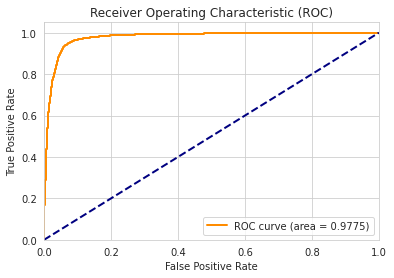

Validation Loss: 47.4418, Accuracy: 93.40%


Epoch 2/10: 100%|██████████| 1204/1204 [06:20<00:00,  3.16it/s]


Epoch 2/10, Training Loss: 0.2056046502163442


Validation: 100%|██████████| 258/258 [01:15<00:00,  3.42it/s]


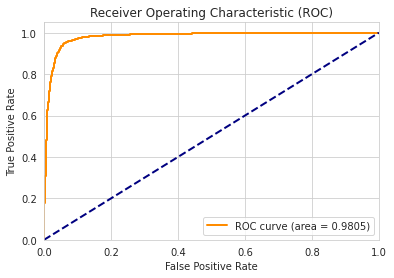

Validation Loss: 42.8728, Accuracy: 94.26%


Epoch 3/10: 100%|██████████| 1204/1204 [06:33<00:00,  3.06it/s]


Epoch 3/10, Training Loss: 0.19233049168885744


Validation: 100%|██████████| 258/258 [01:10<00:00,  3.68it/s]


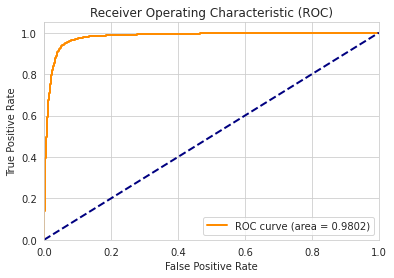

Validation Loss: 44.3541, Accuracy: 94.33%


Epoch 4/10: 100%|██████████| 1204/1204 [06:15<00:00,  3.21it/s]


Epoch 4/10, Training Loss: 0.1849515931340448


Validation: 100%|██████████| 258/258 [01:12<00:00,  3.58it/s]


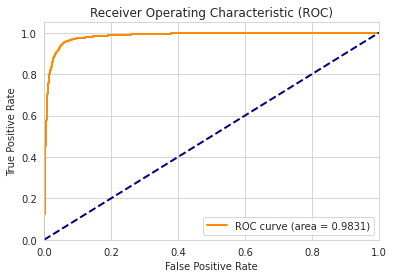

Validation Loss: 41.0565, Accuracy: 94.43%


Epoch 5/10: 100%|██████████| 1204/1204 [06:26<00:00,  3.12it/s]


Epoch 5/10, Training Loss: 0.17429990781025584


Validation: 100%|██████████| 258/258 [01:11<00:00,  3.61it/s]


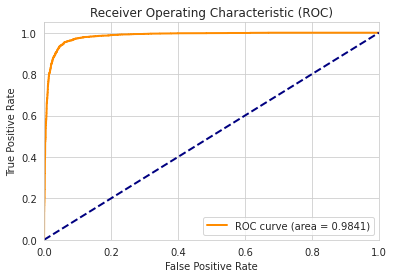

Validation Loss: 39.5235, Accuracy: 94.53%


Epoch 6/10: 100%|██████████| 1204/1204 [06:20<00:00,  3.17it/s]


Epoch 6/10, Training Loss: 0.16857847494175318


Validation: 100%|██████████| 258/258 [01:10<00:00,  3.64it/s]


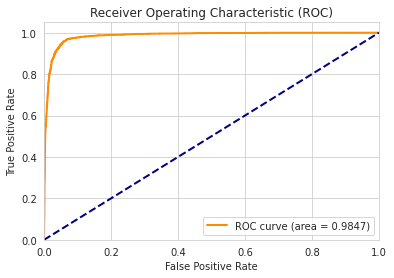

Validation Loss: 40.1278, Accuracy: 94.46%


Epoch 7/10: 100%|██████████| 1204/1204 [06:14<00:00,  3.21it/s]


Epoch 7/10, Training Loss: 0.16129861123073982


Validation: 100%|██████████| 258/258 [01:11<00:00,  3.62it/s]


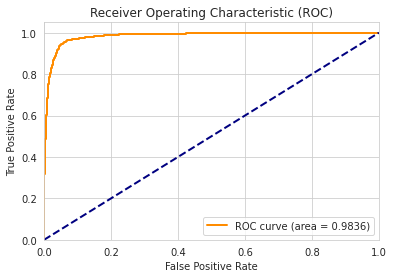

Validation Loss: 42.0772, Accuracy: 94.32%


Epoch 8/10: 100%|██████████| 1204/1204 [05:58<00:00,  3.36it/s]


Epoch 8/10, Training Loss: 0.15210595556482226


Validation: 100%|██████████| 258/258 [01:04<00:00,  3.99it/s]


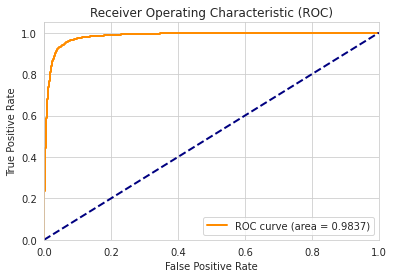

Validation Loss: 43.0791, Accuracy: 94.49%


Epoch 9/10: 100%|██████████| 1204/1204 [05:44<00:00,  3.49it/s]


Epoch 9/10, Training Loss: 0.1449762948578304


Validation: 100%|██████████| 258/258 [01:07<00:00,  3.81it/s]


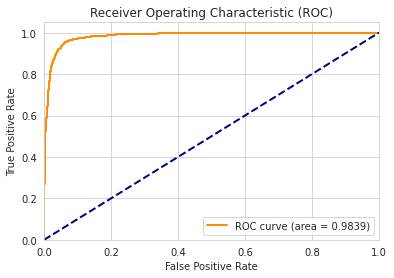

Validation Loss: 41.0610, Accuracy: 94.20%


Epoch 10/10: 100%|██████████| 1204/1204 [05:57<00:00,  3.37it/s]


Epoch 10/10, Training Loss: 0.14097735885549276


Validation: 100%|██████████| 258/258 [01:09<00:00,  3.73it/s]


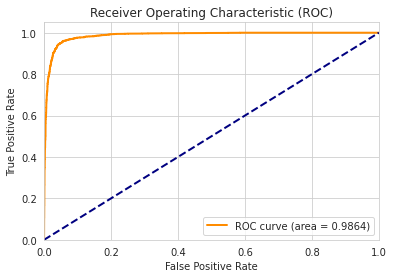

Validation Loss: 37.7602, Accuracy: 95.18%


Testing: 100%|██████████| 258/258 [01:05<00:00,  3.97it/s]


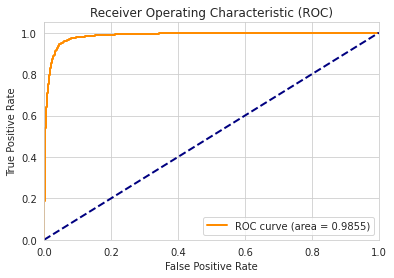

Test Loss: 0.1519, Accuracy: 94.96%


'\nfor epoch in range(epochs):\n    model.train()\n    correct = 0\n    total = 0\n    running_loss = 0.0\n\n    for data in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):\n        inputs, ages, anatom_sites, sexs, labels = [item.to(device) for item in data]\n\n        optimizer.zero_grad()\n\n        outputs = model(inputs)\n        loss = loss_fn(outputs, labels)\n\n        loss.backward()\n        optimizer.step()\n\n        running_loss += loss.item()\n\n        _, predicted = torch.max(outputs, 1)\n        total += labels.size(0)\n        correct += (predicted == labels).sum().item()\n\n    epoch_loss = running_loss / len(train_loader)\n    epoch_accuracy = correct / total\n\n    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2%}")\n    val_loss, val_acc, val_auc = validate_model(model, valid_loader, loss_fn, device)\n\n    # 在验证完成后进行测试  \n    test_loss, test_acc = test_model(model, test_loader, criterion, device)  \n\nprint("Training, 

In [32]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# Validation function
def validate_model(model, val_loader, criterion, device):  
    model.eval()  # Set to evaluation mode  
    val_loss = 0.0  
    correct = 0  
    total = 0  
    all_labels = []
    all_probs = []
    with torch.no_grad():  
        for images, labels in tqdm(val_loader, desc="Validation"):  
            images = images.to(device)  
            labels = labels.to(device)  
            outputs = model(images)  
            loss = criterion(outputs, labels)  
            val_loss += loss.item()  
            _, predicted = torch.max(outputs, 1)  
            total += labels.size(0)  
            correct += (predicted == labels).sum().item()  
            
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(torch.softmax(outputs, dim=1)[:, 1].cpu().numpy())  # Use probability of class 1
    
    # Compute AUC
    val_auc = roc_auc_score(all_labels, all_probs)
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % val_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()
    
    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {correct / total:.2%}")  

# Testing function  
def test_model(model, test_loader, criterion, device):  
    model.eval()  # Set to evaluation mode  
    test_loss = 0.0  
    correct = 0  
    total = 0  
    all_labels = []
    all_probs = []
    with torch.no_grad():  
        for images, labels in tqdm(test_loader, desc="Testing"):  
            images = images.to(device)  
            labels = labels.to(device)  
            outputs = model(images)  
            loss = criterion(outputs, labels)  
            test_loss += loss.item()  
            _, predicted = torch.max(outputs, 1)  
            total += labels.size(0)  
            correct += (predicted == labels).sum().item()  

            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(torch.softmax(outputs, dim=1)[:, 1].cpu().numpy())  # Use probability of class 1
    
    # Compute AUC
    test_auc = roc_auc_score(all_labels, all_probs)
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % test_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()
    
    print(f"Test Loss: {test_loss / len(test_loader):.4f}, Accuracy: {correct / total:.2%}")  

'''def validate_model(model, val_loader, criterion, device):  
    model.eval()  # 设置为评估模式  
    val_loss = 0.0  
    correct = 0  
    total = 0  
    with torch.no_grad():  # 不需要计算梯度  
        for data in tqdm(val_loader, desc="Validation"):  
            inputs, ages, anatom_sites, sexs, labels = [item.to(device) for item in data]  
            outputs = model(inputs)  
            loss = criterion(outputs, labels)  
            val_loss += loss.item()  
            _, predicted = torch.max(outputs, 1)  
            total += labels.size(0)  
            correct += (predicted == labels).sum().item()  
    val_loss /= len(val_loader)  
    val_accuracy = correct / total  
    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2%}")  
    return val_loss, val_accuracy  
  
# 测试函数  
def test_model(model, test_loader, criterion, device):  
    model.eval()  # 设置为评估模式  
    test_loss = 0.0  
    correct = 0  
    total = 0  
    with torch.no_grad():  # 不需要计算梯度  
        for data in tqdm(test_loader, desc="Testing"):  
            inputs, ages, anatom_sites, sexs, labels = [item.to(device) for item in data]  
            outputs = model(inputs)  
            loss = criterion(outputs, labels)  
            test_loss += loss.item()  
            _, predicted = torch.max(outputs, 1)  
            total += labels.size(0)  
            correct += (predicted == labels).sum().item()  
    test_loss /= len(test_loader)  
    test_accuracy = correct / total  
    print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2%}")  
    return test_loss, test_accuracy 

'''
'''
# Training the model
model = densenet

epochs = 10

for epoch in range(epochs):
    model.train()
    correct = 0
    total = 0
    running_loss = 0.0

    for data in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        inputs, ages, anatom_sites, sexs, labels = [item.to(device) for item in data]

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = loss_fn(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct / total

    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2%}")
    val_loss, val_acc = validate_model(model, valid_loader, criterion, device)  
    
''' 
densenet = densenet.to(device)

model = densenet

epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {running_loss / len(train_loader)}")
    validate_model(model, valid_loader, loss_fn, device)

# Test the model
test_model(model, test_loader, loss_fn, device)
'''
for epoch in range(epochs):
    model.train()
    correct = 0
    total = 0
    running_loss = 0.0

    for data in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        inputs, ages, anatom_sites, sexs, labels = [item.to(device) for item in data]

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = loss_fn(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct / total

    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2%}")
    val_loss, val_acc, val_auc = validate_model(model, valid_loader, loss_fn, device)

    # 在验证完成后进行测试  
    test_loss, test_acc = test_model(model, test_loader, criterion, device)  

print("Training, Validation, and Testing complete!")
'''

In [33]:
torch.save(densenet.state_dict(), 'densenet_model1.pth')
print("Model saved successfully!")

Model saved successfully!


In [34]:
###Inception###

In [53]:
'''
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.models import inception_v3

# Load the Inception model
model = inception_v3(pretrained=True).to(device)
# print(model)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
model = model.to(device)

# support another imput sizing
train_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.5),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=5)], p=0.5),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=7)], p=0.5),
    transforms.RandomApply([transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10)], p=0.5),
    transforms.RandomApply([transforms.RandomPerspective(distortion_scale=0.5)], p=0.5),
    transforms.ToTensor(),  
])

# Define transforms for the data (adjust as necessary)
test_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(), 
])

# Define dataset and dataloaders for train and test sets
train_dataset = CustomDataset(train_data, transform=train_transform)
valid_dataset = CustomDataset(valid_data, transform=test_transform)
test_dataset = CustomDataset(test_data, transform=test_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=True)
print('Data loading and preprocessing completed.')
'''
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.models import inception_v3
from custom_dataset import CustomDataset  # 导入CustomDataset类

# Load the Inception model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = inception_v3(pretrained=True).to(device)

# 修改模型，只保留图像信息
# 去掉最后的全连接层
model.fc = nn.Identity()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Define transforms for the data (adjust as necessary)
transform = transforms.Compose([
    transforms.Resize((299, 299)),  # 调整图像大小
    transforms.ToTensor(),  # 转换为张量
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 标准化
])

# 定义数据集和数据加载器
train_dataset = ImageDataset(train_data, transform=train_transform)
valid_dataset = ImageDataset(valid_data, transform=test_transform)
test_dataset = ImageDataset(test_data, transform=test_transform)

# 定义数据加载器
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True,num_workers=8)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False,num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=True,num_workers=8)


print('Data loading and preprocessing completed.')


Data loading and preprocessing completed.


In [54]:
for batch in train_loader:
    print(batch)
    break


[tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# Validation function
def validate_model(model, val_loader, criterion, device):  
    model.eval()  # Set to evaluation mode  
    val_loss = 0.0  
    correct = 0  
    total = 0  
    all_labels = []
    all_probs = []
    with torch.no_grad():  
        for images, labels, _, _, _ in tqdm(val_loader, desc="Validation"):  # 修改此处
            images = images.to(device)  
            labels = labels.to(device)  
            outputs = model(images)  
            loss = criterion(outputs.logits, labels)  # 修改此处
            val_loss += loss.item()  
            _, predicted = torch.max(outputs.logits, 1)  # 修改此处
            total += labels.size(0)  
            correct += (predicted == labels).sum().item()  
            
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(torch.softmax(outputs.logits, dim=1)[:, 1].cpu().numpy())  # Use probability of class 1
    
    # Compute AUC
    val_auc = roc_auc_score(all_labels, all_probs)
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % val_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()
    
    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {correct / total:.2%}")  

# Testing function  
def test_model(model, test_loader, criterion, device):  
    model.eval()  # Set to evaluation mode  
    test_loss = 0.0  
    correct = 0  
    total = 0  
    all_labels = []
    all_probs = []
    with torch.no_grad():  
        for images, labels, _, _, _ in tqdm(test_loader, desc="Testing"):  # 修改此处
            images = images.to(device)  
            labels = labels.to(device)  
            outputs = model(images)  
            loss = criterion(outputs.logits, labels)  # 修改此处
            test_loss += loss.item()  
            _, predicted = torch.max(outputs.logits, 1)  # 修改此处
            total += labels.size(0)  
            correct += (predicted == labels).sum().item()  

            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(torch.softmax(outputs.logits, dim=1)[:, 1].cpu().numpy())  # Use probability of class 1
    
    # Compute AUC
    test_auc = roc_auc_score(all_labels, all_probs)
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % test_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()
    
    print(f"Test Loss: {test_loss / len(test_loader):.4f}, Accuracy: {correct / total:.2%}")  

    
display(valid_loader)
display(test_loader)
# Training the model
# Move the Inception model to the appropriate device
model = model.to(device)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Number of epochs
epochs = 10

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs.logits, labels)  # 修改此处
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {running_loss / len(train_loader)}")
    validate_model(model, valid_loader, criterion, device)

# Test the model
test_model(model, test_loader, criterion, device)

Epoch 1/10:   1%|          | 15/1203 [00:06<04:20,  4.55it/s] 

In [ ]:
torch.save(inception.state_dict(), 'inception_model1.pth')
print("Model saved successfully!")